In [0]:
# #colabを使う方はこちらを使用ください。
# !pip install torch==0.4.1
# !pip install torchvision==0.2.1
# !pip install numpy==1.14.6
# !pip install matplotlib==2.1.2
# !pip install pillow==5.0.0
# !pip install opencv-python==3.4.3.18
# !pip install torchtext==0.3.1

In [0]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torchtext import data
from torchtext import vocab
from torchtext import datasets

%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# データとモデルに.to(device)を指定してgpuの計算資源を使用する。
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# LSTMを使用した文章分類：IMDB

## データの読み込み

In [0]:
# ハイパーパラメータ
batch_size = 32 #バッチサイズ
output_size = 2 #fcの出力次元
hidden_size = 256 #lstmの出力次元
embedding_length = 300 #埋め込みベクトルの出力次元

In [5]:
# 前処理用の機能のFieldをセットアップ
# トークン化の方式を指定
tokenize = lambda x: x.split()
#Field
TEXT = data.Field(sequential=True, tokenize=tokenize, lower=True, include_lengths=True, batch_first=True, fix_length=200)
#LabelField
LABEL = data.LabelField()
# データを分割
train_dataset, test_dataset = datasets.IMDB.splits(TEXT, LABEL)
train_dataset, val_dataset = train_dataset.split()

print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

aclImdb_v1.tar.gz:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:02<00:00, 28.4MB/s]


17500
7500
25000


In [6]:
# build_vocabで単語の辞書を構築。IDと単語の一覧が作成されます。
# 学習済み埋め込みベクトルに適応
TEXT.build_vocab(train_dataset, vectors=vocab.GloVe(name='6B', dim=300))
LABEL.build_vocab(train_dataset)

# 単語の件数のtop10
print(TEXT.vocab.freqs.most_common(10))
# ラベルごと件数
print(LABEL.vocab.freqs)
# 単語
print(TEXT.vocab.itos[:10])
# BucketIteratorでバッチ単位にします。
train_iter, val_iter, test_iter = data.BucketIterator.splits((train_dataset, val_dataset, test_dataset), batch_size=32, sort_key=lambda x: len(x.text), repeat=False, shuffle=True)

vocab_size = len(TEXT.vocab)
word_embeddings = TEXT.vocab.vectors

.vector_cache/glove.6B.zip: 862MB [00:14, 60.9MB/s]                           
100%|█████████▉| 399466/400000 [00:49<00:00, 8071.08it/s]

[('the', 225885), ('a', 111746), ('and', 110705), ('of', 100944), ('to', 93483), ('is', 72854), ('in', 63307), ('i', 49398), ('this', 48687), ('that', 46267)]
Counter({'pos': 8797, 'neg': 8703})
['<unk>', '<pad>', 'the', 'a', 'and', 'of', 'to', 'is', 'in', 'i']


In [7]:
for i, batch in enumerate(train_iter):
    print(batch.text[0].size())
    print(batch.text[1].size())
    print(batch.label.size())
    print("１データ目の単語列を表示")
#     print(batch.text[0][0])
#     print(batch.text[1][0])
#     print(batch.label[0])
    print([TEXT.vocab.itos[data] for data in  batch.text[0][0].tolist()])
    print(batch.label[0].item())
    break

torch.Size([32, 200])
torch.Size([32])
torch.Size([32])
１データ目の単語列を表示
['cowboys', 'james', 'stewart', 'and', 'walter', 'brennan', 'take', 'their', 'herd', 'from', 'seattle', 'to', 'alaska', 'and', 'on', 'into', 'canada', 'to', 'stake', 'a', 'claim.', 'once', 'there,', 'they', 'have', 'to', 'contend', 'with', 'seductive,', 'shifty', 'businesswoman', 'ruth', 'roman', 'and', 'ice-cold,', 'happy-go-lucky', 'villain', 'james', 'mcintire.<br', '/><br', '/>john', 'wayne', 'may', 'get', 'talked', 'about', 'more,', 'but', 'his', 'good', 'pal', 'stewart', 'made', 'some', 'excellent,', 'hard-edged', 'westerns', 'too,', 'some', 'with', 'the', 'great', 'director', 'anthony', 'mann.', 'frankly,', "i'd", 'take', 'this,', 'with', "it's", 'sturdy', 'action', 'sequences', 'and', 'fine', 'melodrama,', 'over', 'north', 'to', 'alaska', 'any', 'day!<br', '/><br', '/>the', 'far', 'country', 'features', 'some', 'breathtaking', 'scenery', 'and', 'cinematography', 'that', 'should', 'definitely', 'have', 'been', 

## ネットワークを定義

In [8]:
class LstmClassifier(nn.Module):
    def __init__(self, batch_size, hidden_size, output_size, vocab_size, embedding_length, weights):
        super(LstmClassifier, self).__init__()
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.vocab_size = vocab_size
        self.embed = nn.Embedding(vocab_size, embedding_length)
        self.embed.weight.data.copy_(weights)
        self.lstm = nn.LSTM(embedding_length, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.embed(x)
        # 初期隠れ状態とセル状態を設定
        h0 = torch.zeros(1, self.batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(1, self.batch_size, self.hidden_size).to(device)
        # LSTMを伝播する
        # output_seqの出力形状：（バッチサイズ、シーケンス長、出力次元）
        output_seq, (h_n, c_n) = self.lstm(x, (h0, c0))        
        # 最後のタイムステップの隠れ状態をデコード
        out = self.fc(h_n[-1]) 
        return out

net = LstmClassifier(batch_size, hidden_size, output_size, vocab_size, embedding_length, word_embeddings)
net = net.to(device)


100%|█████████▉| 399466/400000 [01:00<00:00, 8071.08it/s]

In [0]:
# 損失関数、最適化関数を定義
criterion = nn.CrossEntropyLoss()
optim = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()))

## 学習

In [10]:
num_epochs = 10

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    #train
    net.train()
    for i, batch in enumerate(train_iter):
      text = batch.text[0]
      text = text.to(device)
      if (text.size()[0] is not 32):
        continue
      labels = batch.label
      labels = labels.to(device)
      optim.zero_grad()
      outputs = net(text)
      loss = criterion(outputs, labels)
      train_loss += loss.item()
      train_acc += (outputs.max(1)[1] == labels).sum().item()
      loss.backward()
      optim.step()
    avg_train_loss = train_loss / len(train_iter.dataset)
    avg_train_acc = train_acc / len(train_iter.dataset)
    
    #val
    net.eval()
    with torch.no_grad():
      for batch in val_iter:
        text = batch.text[0]
        text = text.to(device)
        if (text.size()[0] is not 32):
          continue
        labels = batch.label
        labels = labels.to(device)
        outputs = net(text)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(val_iter.dataset)
    avg_val_acc = val_acc / len(val_iter.dataset)
    
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)


Epoch [1/10], Loss: 0.0213, val_loss: 0.0208, val_acc: 0.5865
Epoch [2/10], Loss: 0.0170, val_loss: 0.0118, val_acc: 0.8401
Epoch [3/10], Loss: 0.0053, val_loss: 0.0132, val_acc: 0.8359
Epoch [4/10], Loss: 0.0007, val_loss: 0.0152, val_acc: 0.8407
Epoch [5/10], Loss: 0.0002, val_loss: 0.0249, val_acc: 0.8389
Epoch [6/10], Loss: 0.0001, val_loss: 0.0211, val_acc: 0.8325
Epoch [7/10], Loss: 0.0000, val_loss: 0.0284, val_acc: 0.8365
Epoch [8/10], Loss: 0.0000, val_loss: 0.0290, val_acc: 0.8343
Epoch [9/10], Loss: 0.0000, val_loss: 0.0343, val_acc: 0.8311
Epoch [10/10], Loss: 0.0000, val_loss: 0.0379, val_acc: 0.8309


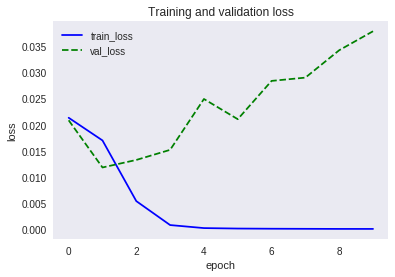

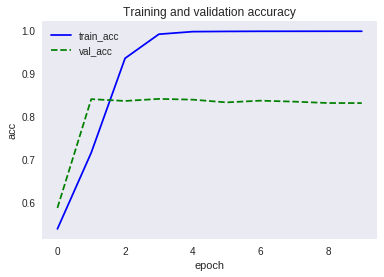

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

## 推論

In [12]:
net.eval()
with torch.no_grad():
    total = 0
    test_acc = 0
    for batch in test_iter:
        text = batch.text[0]
        text = text.to(device)
        if (text.size()[0] is not 32):
          continue
        labels = batch.label
        labels = labels.to(device)

        outputs = net(text)
        test_acc += (outputs.max(1)[1] == labels).sum().item()
        total += labels.size(0)
    print('精度: {} %'.format(100 * test_acc / total)) 

torch.save(net.state_dict(), 'net.pt')


精度: 80.03361075544174 %
